# Como lake data exploration

Data obtained from the archive of *ARPA Lombardia* ([link](https://www.arpalombardia.it/Pages/Ricerca-Dati-ed-Indicatori.aspx)), we will use tables "Afflussi settimanali per bacino" for all the available years (2011-2018), expressed in $m^3 \cdot 10^6$. The data gives inflows for each lake in the region, but we are interested in just the `"MERA"` and `"ADDA PRELACUALE"` (i.e. Adda before the lake) rivers, as they represent the two main sources of water of the Como lake.

In [195]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os

First, import the different datasets and build the complete one:

In [267]:
# Get the names of the files
filenames = os.listdir('data')
filenames.sort()

# Get data from the files and concatenate them in a single df
full_df = pd.DataFrame()

for name in list(filenames):
    
    # Read data
    print(name)
    df = pd.read_excel('data/'+name, 
                       skiprows = range(0,12),
                       usecols = 'A,I,J')
    
    # Remove empty rows
    df = df.dropna(axis=0, how='all') 
    
    # Split week interval into two columns (start and end week)
    # (We have to be careful because date written in 2 different ways in the files)
    if df['SETTIMANA'][0][:5] == "01/01":
        df['From'] = df['SETTIMANA'].str[:5]
        df['To']   = df['SETTIMANA'].str[-5:]
    elif df['SETTIMANA'][0][:3] == "1/1":
        df[['From','To']] = df['SETTIMANA'].str.split("-",expand=True,)
    else:
        print('\n\n There is a problem in the date format \n\n')
        
    df.drop(['SETTIMANA'], axis=1)
    df = df[['From','To','ADDA PRELACUALE','MERA']]
    
    # Convert dates strings into datetimes
    year = name[14:18]
    df['From'] = df['From'] + '/' + year
    df['To']   = df['To']   + '/' + year
    df['From'] = pd.to_datetime(df['From'], format='%d/%m/%Y')
    df['To']   = pd.to_datetime(df['To'], format='%d/%m/%Y')
    
    # Correct dates of 2014 (they are shifted of one day)
    if year == '2014':
        df['From'] -= datetime.timedelta(days=1)
        df['To']   -= datetime.timedelta(days=1)
        
    
    # Build full dataset to contain all years
    full_df = pd.concat([full_df,df]).reset_index(drop=True)
    
    
# Reset indexes of the full dataset 
# (before, indexes restart at each year) 
full_df = full_df.reset_index(drop=True)


afflussi_sett_2011.xlsx
afflussi_sett_2012.xlsx
afflussi_sett_2013.xlsx
afflussi_sett_2014.xlsx
afflussi_sett_2015.xlsx
afflussi_sett_2016.xlsx
afflussi_sett_2017.xlsx
afflussi_sett_2018.xlsx


At the moment each row represents the weekly inflows but, if a week is spanned between two moths/years, it is splitted in two entries.</br>
Now we will join those portions of weeks to have a uniform unit of time (a week).

In [268]:
# Find rows that do not represent full weeks (pairs of rows)
week_len = (full_df['To'] - full_df['From'])[1:-1]
partial_weeks = week_len.index[week_len!=datetime.timedelta(days=6)][::2]

# Add inflow values between these splitted weeks
inflows = (full_df.reset_index()
                  .replace({'index': dict(zip(partial_weeks+1,partial_weeks))})
                  .groupby('index', sort=False).sum() )

# Update end-date of the first portion of these weeks
full_df['To'][partial_weeks] = full_df['To'][partial_weeks+1]

# Remove second portions of the partial weeks and add complete inflows
full_df[['ADDA PRELACUALE','MERA']] = inflows
full_df = full_df.drop(partial_weeks+1)


<ipython-input-268-7a65947efdb5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['To'][partial_weeks] = full_df['To'][partial_weeks+1]


In [269]:
### TEST ###

# Find rows that do not represent full weeks (pairs of rows)
week_len = (full_df['To'] - full_df['From'])[1:-1]
partial_weeks = week_len.index[week_len!=datetime.timedelta(days=6)][::2]
partial_weeks

Int64Index([], dtype='int64')

Now, each entry of our dataframe correspond to the inflows of the two rivers during a week (i.e. a period of always 7 days)

In [271]:
# Final weekly inflow dataset
full_df

,From,To,ADDA PRELACUALE,MERA
0,2011-01-01,2011-01-02,0.0,0.1
1,2011-01-03,2011-01-09,71.4,41.1
2,2011-01-10,2011-01-16,53.7,13.2
3,2011-01-17,2011-01-23,0.2,0.2
4,2011-01-24,2011-01-30,0.3,0.1
...,...,...,...,...
487,2018-12-03,2018-12-09,15.4,7.6
488,2018-12-10,2018-12-16,3.1,0.9
489,2018-12-17,2018-12-23,13.1,6.4
490,2018-12-24,2018-12-30,8.6,4.7


## Study distribution of these inflows

First, let's visualize these values in a single plot:

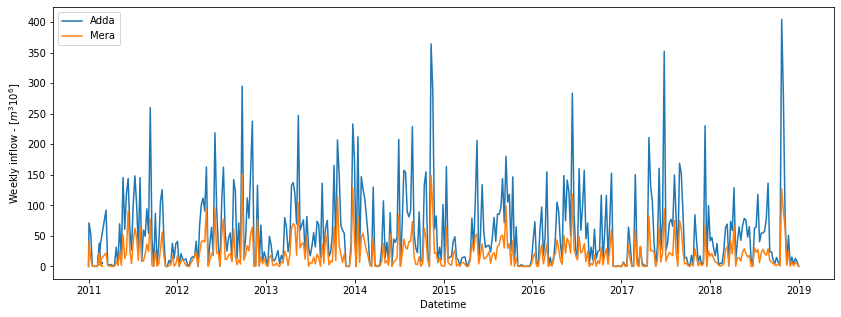

In [272]:
# Extract the two time series from the dataset
adda_inflow = full_df[['From','ADDA PRELACUALE']].set_index('From')
mera_inflow = full_df[['From','MERA']].set_index('From')

# Plot them
plt.figure(figsize=(14,5))
plt.plot(adda_inflow, label = "Adda")
plt.plot(mera_inflow, label = "Mera")
plt.xlabel('Datetime')
plt.ylabel('Weekly inflow - [$m^310^6$]')
plt.legend()
plt.show()

Now, I would assume that there should be a seasonal component in these values, let's see if such component can be found in the data.

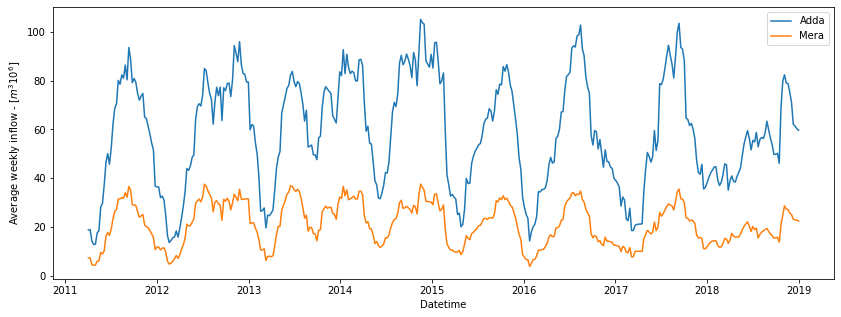

'\n# Plot residuals from this moving average\nplt.figure(figsize=(14,5))\nplt.plot(adda_inflow - adda_MA, label = "Adda")\nplt.xlabel(\'Datetime\')\nplt.ylabel(\'Noises - [$m^310^6$]\')\nplt.legend()\nplt.show()\n'

In [273]:
# Perform moving average
window_size = 15
adda_MA = adda_inflow.rolling(window_size).mean()
mera_MA = mera_inflow.rolling(window_size).mean()

# Plot filtered signals
plt.figure(figsize=(14,5))
plt.plot(adda_MA, label = "Adda")
plt.plot(mera_MA, label = "Mera")
plt.xlabel('Datetime')
plt.ylabel('Average weekly inflow - [$m^310^6$]')
plt.legend()
plt.show()

"""
# Plot residuals from this moving average
plt.figure(figsize=(14,5))
plt.plot(adda_inflow - adda_MA, label = "Adda")
plt.xlabel('Datetime')
plt.ylabel('Noises - [$m^310^6$]')
plt.legend()
plt.show()
"""

As expected, is possible to see a seasonal component: there is a clear minimum in the inflows of both rivers during the winter (not on 2014). In order to compute how much the season impacts the inflows values, we need to model this component(?)

Here there are some experiments with few libraries to see how the seasonal component can be extracted.

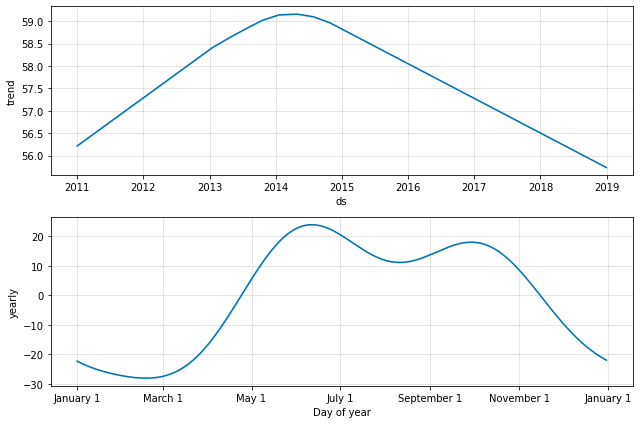

In [298]:
from fbprophet import Prophet
import fbprophet.plot as fbp

# format data to be compatible with the library
adda_test = full_df[['From','ADDA PRELACUALE']]
adda_test.columns = ['ds','y']

# Find seasonality (fit it using fourier series of given order)
model = Prophet(yearly_seasonality = 3, 
                weekly_seasonality = False,
                daily_seasonality  = False)
model.fit(adda_test)

# Build estimated inflows
adda_estim = model.predict()

# Print fitted components
model.plot_components(adda_estim)
plt.show()

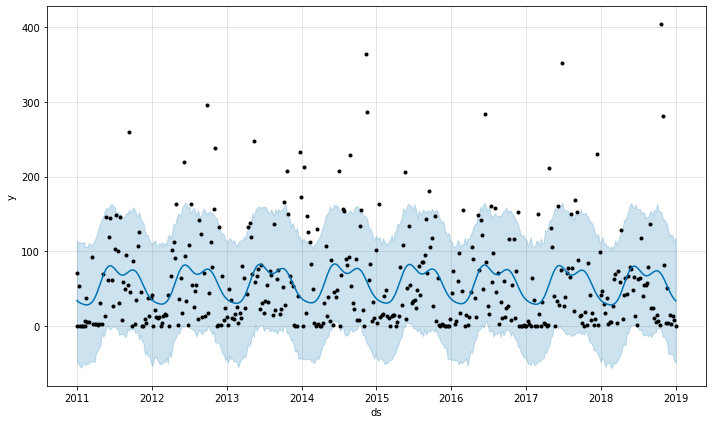

In [299]:
# Plot the estimated inflow
model.plot(adda_estim)
plt.show()

# useful data is in adda_estim[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

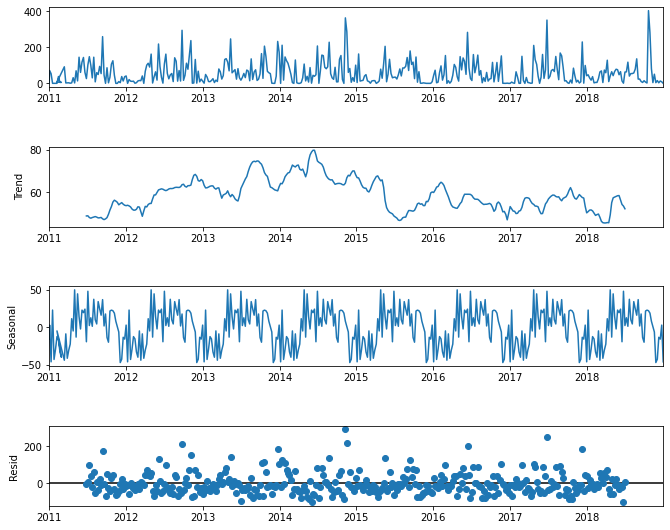

In [293]:
# JUST A TEST WITH ANOTHER LIBRARY

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(adda_inflow, model='additive', period=52)
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()